In [1]:
# Since we know we don't have enough flux to get LSST u filter magnitudes, let's see if we can 
# interpolate from the fe/H and g-r

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from lsst.sims.utils import raDec2Hpid
from lsst.utils import getPackageDir
import os
import healpy as hp
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy import interpolate


from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline


In [2]:
ack = np.load('0_33578_gum_mag_cat.npz')
stars = ack['result_cat'].copy()
ack.close()

In [3]:
# Make a correction so now only the random noise is left.
good = np.where(stars['g'] != 0)
filters = ['u', 'u_truncated', 'g', 'r', 'i', 'z', 'y', 'y_truncated']
for fn in filters:
    diff = stars[fn+'_noiseless'][good]-stars[fn+'_true'][good]
    stars[fn][good] -= diff

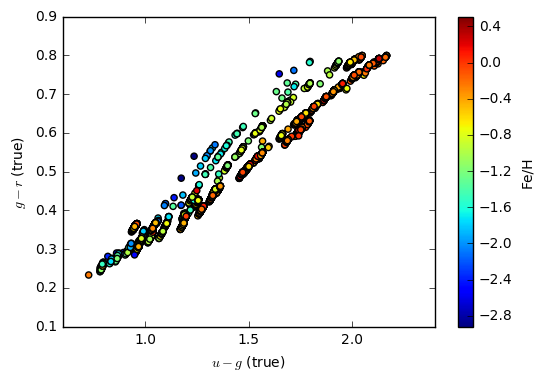

In [4]:
# define MS. I think this limits things to FGK stars about
MS = np.where((stars['g_true']-stars['r_true'] > 0.2) & (stars['g_true']-stars['r_true'] < 0.8) & (stars['g'] != 0))
MS_train = np.where((stars['g_true']-stars['r_true'] > 0.2) & (stars['g_true']-stars['r_true'] < 0.8) & 
                   (stars['Av'] < .15)& (stars['g'] != 0))
plt.scatter(stars['u_true'][MS_train] - stars['g_true'][MS_train], 
            stars['g_true'][MS_train] - stars['r_true'][MS_train], c=stars['feH'][MS_train])
cb = plt.colorbar()
cb.set_label('Fe/H')
plt.xlabel('$u-g$ (true)')
plt.ylabel('$g-r$ (true)')

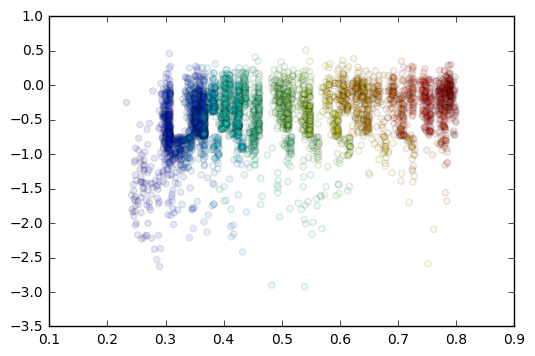

In [5]:
plt.scatter(stars['g_true'][MS_train] - stars['r_true'][MS_train], stars['feH'][MS_train], 
            c=stars['u_true'][MS_train] - stars['g_true'][MS_train], alpha=.1)

In [53]:
# Let's estimate the metallicity errors from this paper: http://adsabs.harvard.edu/abs/2012MNRAS.426.2463L
# at G=15, fe/H "to 0.1-0.2 dex". at G=19, Fe/H to within 0.35.
g_i = stars['g_true']-stars['i_true']
ack = + 0.0094 + 0.531*(g_i) + 0.0974*(g_i)**2 - 0.0052*(g_i)**3
gaia_G = stars['g'] - ack
# simple linear fit
max_feh_err = (0.15/4.)*gaia_G - 0.3625
# I dunno, a flat distribution on the errors up to the max
#fe_h_err = (np.random.rand(max_feh_err.size)*2-1.)*max_feh_err

fe_h_err = (np.random.rand(max_feh_err.size))*max_feh_err/3.


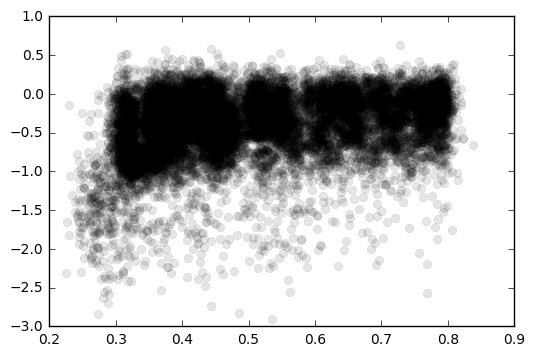

In [54]:
plt.plot(stars['g'][MS]-stars['r'][MS], stars['feH'][MS]+fe_h_err[MS], 'ko', alpha=.1)

In [55]:
X = np.vstack((stars['g_true'][MS_train] - stars['r_true'][MS_train], stars['feH'][MS_train]))


In [56]:
model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                  ('linear', LinearRegression(fit_intercept=False))])
#model = Pipeline([('linear', LinearRegression(fit_intercept=False))])
model = model.fit(X.T,stars['u_true'][MS_train] - stars['g_true'][MS_train])

In [57]:
measured_X = np.vstack((stars['g'][MS]-stars['r'][MS], stars['feH'][MS]+fe_h_err[MS])).T
recovered_u_g = model.predict(measured_X)
recovered_u = recovered_u_g+stars['g'][MS]


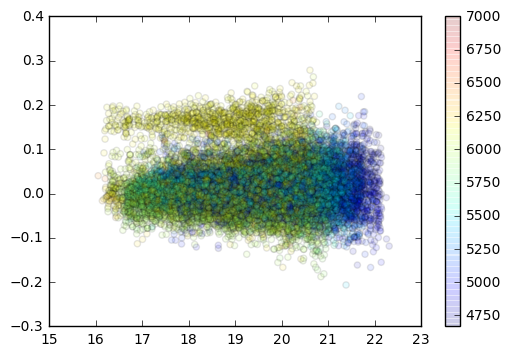

In [58]:
fn = 'u'
plt.scatter(stars[fn+'_true'][MS], recovered_u-stars[fn+'_true'][MS], c=stars['teff'][MS], alpha=.1, vmax=7000)
cb = plt.colorbar()

array([-0.40331108])

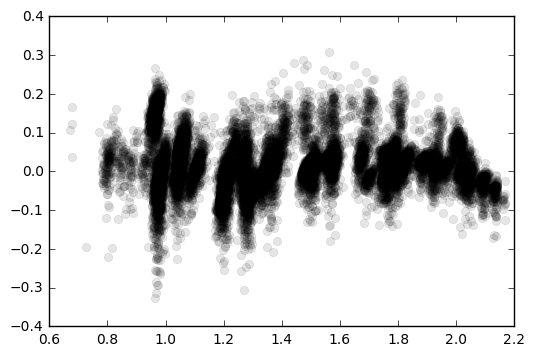

In [44]:
u_g = stars['u_true']-stars['g_true']
plt.plot(u_g[MS], recovered_u_g-u_g[MS], 'ko', alpha=.1)

In [ ]:
# Next steps--Let's step through the Kurucz models and make a better grid of u-g, g-r, feH. Then we train on that instead.
